In [57]:
import warnings
warnings.filterwarnings("ignore")

from torchvision import datasets, transforms
import torchmetrics.functional as FM
import torch
import torch.nn.functional as F

import matplotlib.pyplot as plt
import random


import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger

print('GPU available:', torch.cuda.is_available())

GPU available: True


In [68]:
emnist_train = datasets.EMNIST(root='./emnist', split='letters', train=True, download=False, transform=transforms.ToTensor())
emnist_test = datasets.EMNIST(root='./emnist', split='letters', train=False, download=False, transform=transforms.ToTensor())
emnist_train.targets -= 1 # Т.к. изначально нумерация классов начинается с 1, мы понижаем индексы на 1
emnist_test.targets -= 1 # Аналогично
print('Length of train:', len(emnist_train))
print('Length of test:', len(emnist_test))
print('Unique labels:', len((emnist_train.targets).unique()))
print('Labels:', emnist_train.targets.unique())

Length of train: 124800
Length of test: 20800
Unique labels: 26
Labels: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25])


In [69]:
def show_pictures(shape, pics, labels):
    vis_img = random.choices(pics, k=shape[0] * shape[1])
    vis_labels = random.choices(labels, k=shape[0] * shape[1])
    
    fig, axs = plt.subplots(shape[0], shape[1], figsize=(16, 16))
    for i in range(shape[0]):
        for j in range(shape[1]):
            axs[i, j].imshow(vis_img[i*shape[0] + j])
            axs[i, j].set_title(str(vis_labels[i*shape[0] + j].item()))
    plt.show()

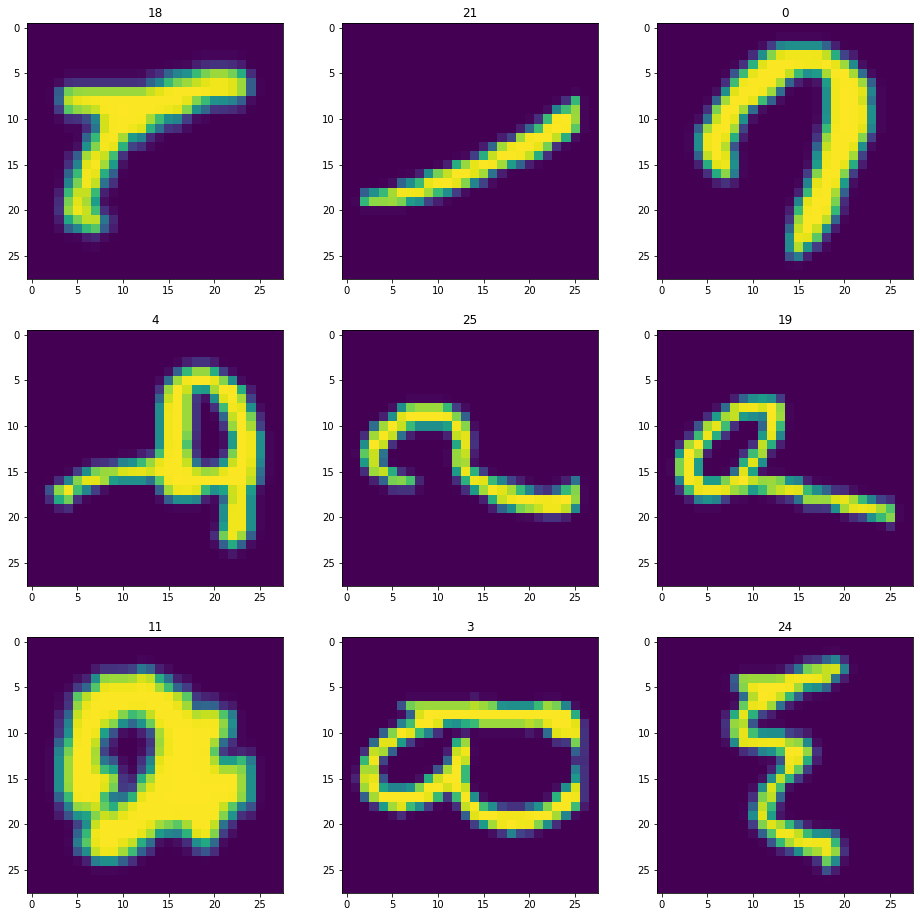

In [70]:
show_pictures((3, 3), emnist_test.test_data, emnist_test.test_labels)

In [75]:
test_dataloader = torch.utils.data.DataLoader(emnist_test, batch_size=128, shuffle=True)
train_dataloader = torch.utils.data.DataLoader(emnist_train, batch_size=128, shuffle=True)

In [82]:
print('Batch targets:\n', next(iter(train_dataloader))[1])

Batch targets:
 tensor([ 7, 17,  8, 21,  2, 11, 12, 22, 21,  5, 13,  7,  8,  1, 21,  9,  2, 19,
        19,  6,  6,  8, 19,  8,  2, 13,  1, 24, 17, 23,  8, 20, 25,  4,  0, 17,
         5,  6,  7, 10,  1,  8, 24,  7, 25, 12,  8,  5, 20,  6,  4,  3,  8, 17,
        18,  5, 20,  5, 21,  1, 25, 20,  9, 18,  8,  4, 22,  8, 11, 14, 23, 21,
        14, 11, 22, 25,  9,  1,  9, 16, 18, 14,  0, 12,  7,  7, 18,  0,  1, 17,
        20, 24, 21,  7,  9, 11, 10, 11,  1, 11, 19, 23,  3, 18, 12,  0, 22,  6,
        22, 19, 11,  9,  7,  3, 14, 14, 11, 25,  5, 21,  4,  6, 18,  9,  0, 20,
         0,  0])


В статье [http://mipal.snu.ac.kr/images/1/16/Dropout_ACCV2016.pdf] приводится Dropout для сверточных сетей. Будем ставить Dropout Layer после ReLu, хотя где-то советуют ставить после Пулинга (а некоторые вообще отрицают полезность Dropout в сверточных сетях, однако статья явно показывает эффективность).
Данная статья [https://openaccess.thecvf.com/content_CVPR_2019/papers/Li_Understanding_the_Disharmony_Between_Dropout_and_Batch_Normalization_by_Variance_CVPR_2019_paper.pdf] говорит о том, что Dropout и BatchNorm вместе работают плохо из-за "Variance shift" (так авторы называют "рассинхронизацию" в обработке распределений обоих методов). Но мы все равно затестим их вместе.
Учитывая BatchNorm, будем ставить слои в следующем порядке: CONV/FC -> BatchNorm -> ReLu -> Dropout.

In [85]:
class ConvClassifier(pl.LightningModule):
    def __init__(self, conv_kernel_size, pooling_kernel_size, p, batchnorm):        
        super(ConvClassifier, self).__init__()
        self.layers = torch.nn.Sequential()
        self.convblock1 = self.create_conv_block(1, 6, conv_kernel_size, pooling_kernel_size, p, batchnorm)
        self.convblock2 = self.create_conv_block(6, 16, conv_kernel_size, pooling_kernel_size, p, batchnorm)
        self.flatten = torch.nn.Sequential(torch.nn.Flatten())
        self.linearblock1 = self.create_linear_block(16*4*4, 120, p)
        self.linearblock2 = self.create_linear_block(120, 84, p)
        self.linear3 = torch.nn.Linear(84, 26)
        
    def create_conv_block(self, in_channels, out_channels, conv_size, pooling_size, p=0, batchnorm=False):      
        conv_block = torch.nn.Sequential()
        conv_block.add_module('conv', torch.nn.Conv2d(in_channels, out_channels, conv_size))
        if batchnorm:
            conv_block.add_module('batch', torch.nn.BatchNorm())
        conv_block.add_module('relu', torch.nn.ReLU())
        conv_block.add_module('dropout', torch.nn.Dropout2d(p=p))
        if pooling_size:
            conv_block.add_module('pool', torch.nn.MaxPool2d(kernel_size=pooling_size))
        return conv_block
    
    def create_linear_block(self, in_features, out_features, p=0, batchnorm=False):
        linear_block = torch.nn.Sequential()
        linear_block.add_module('lin', torch.nn.Linear(in_features, out_features))
        if batchnorm:
            conv_block.add_module('batch', torch.nn.BatchNorm())
        linear_block.add_module('relu', torch.nn.ReLU())
        linear_block.add_module('dropout', torch.nn.Dropout(p=p))
        return linear_block
        
    def forward(self, X):
        out = self.convblock1(X)
        out = self.convblock2(out)
        out = self.flatten(out)
        out = self.linearblock1(out)
        out = self.linearblock2(out)
        out = self.linear3(out)
        return out
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)
    
    def training_step(self, batch, batch_num):
        X, y = batch
        pred = self(X)
        loss = F.cross_entropy(pred, y)
        acc = FM.accuracy(pred, y, num_classes=26)
        self.log("train_loss", loss, prog_bar=True)
        self.log("train_acc", acc, prog_bar=True)
        return loss
        
    def validation_step(self, batch, batch_num):
        X, y = batch
        pred = self(X)
        loss = torch.nn.CrossEntropyLoss(pred, y)
        acc = F.cross_entropy(pred, y, num_classes=26)
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", acc, prog_bar=True)

In [86]:
model = ConvClassifier(4, 2, 0.1, False)
trainer = Trainer()
trainer.fit(model, train_dataloader)

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name         | Type       | Params
--------------------------------------------
0 | layers       | Sequential | 0     
1 | convblock1   | Sequential | 102   
2 | convblock2   | Sequential | 1.6 K 
3 | flatten      | Sequential | 0     
4 | linearblock1 | Sequential | 30.8 K
5 | linearblock2 | Sequential | 10.2 K
6 | linear3      | Linear     | 2.2 K 
--------------------------------------------
44.9 K    Trainable params
0         Non-trainable params
44.9 K    Total params
0.179     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

In [ ]:
%load_ext tensorboard
%tensorboard --logdir lightning_logs/